In [1]:
import sys

sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos\\Python_git')
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos')
import os
import pandas as pd
import dlc_processing_utils
from camera_trigger_preprocessing_utils import *
import seaborn as sns
from fede_geometry import r2, calc_angle_between_vectors_of_points_2d
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
from freely_moving_photometry_analysis.utils.post_processing_utils import remove_exps_after_manipulations, remove_bad_recordings
from freely_moving_photometry_analysis.utils.regression.linear_regression_utils import get_first_x_sessions
from freely_moving_photometry_analysis.utils.regression.regression_plotting_utils import make_box_plot
from freely_moving_photometry_analysis.utils.individual_trial_analysis_utils import get_photometry_around_event
from freely_moving_photometry_analysis.utils.plotting import calculate_error_bars
from freely_moving_photometry_analysis.utils.regression.return_to_centre_regression_utils import get_first_x_sessions_reg_rtc
import numpy as np
from scipy.signal import filtfilt
from scipy.optimize import curve_fit
import pickle
import numpy as np
import pandas as pd
from fede_load_tracking import prepare_tracking_data
from camera_trigger_preprocessing_utils import *
from plotting import *
from numpy.linalg import norm
from dlc_processing_utils import get_raw_photometry_data
from scipy.signal import decimate
#uses python 3.6 env

removing SNL_photo57: ['20211103' '20211109' '20211110' '20211112' '20211115' '20211116'
 '20211118' '20211119' '20211122' '20211124' '20211125']
(100000, 15) (100000, 1)
(100000, 21) (100000, 4)


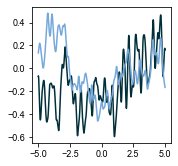

In [47]:
mouse_ids = ['SNL_photo57', 'SNL_photo16', 'SNL_photo17', 'SNL_photo18', 'SNL_photo21', 'SNL_photo22', 'SNL_photo26', 'SNL_photo58', 'SNL_photo70', 'SNL_photo72']
num_sessions = 3
site = 'tail'
# this seems to be working well but maybe too many trials for each session?
experiment_record = pd.read_csv('T:\\photometry_2AC\\experimental_record.csv')
experiment_record['date'] = experiment_record['date'].astype(str)
clean_experiments = remove_exps_after_manipulations(experiment_record, mouse_ids)
all_experiments_to_process = clean_experiments[
    (clean_experiments['mouse_id'].isin(mouse_ids)) & (clean_experiments['recording_site'] == site)].reset_index(
    drop=True)
all_experiments_to_process = all_experiments_to_process[all_experiments_to_process['include return to centre'] != 'no'].reset_index(
    drop=True)
experiments_to_process = get_first_x_sessions_reg_rtc(all_experiments_to_process, x=num_sessions).reset_index(
    drop=True)
all_mice_contra_traces = np.zeros([len(mouse_ids), 100000])
all_mice_ipsi_traces = np.zeros([len(mouse_ids), 100000])
fig1, axs1 = plt.subplots(1, 1, figsize=[2.5, 2.5])
i=0
time_points = np.linspace(-5, 5, 100000)
for mouse_num, mouse in enumerate(mouse_ids):
    experiments = experiments_to_process[experiments_to_process['mouse_id'] == mouse].reset_index(drop=True)
    contra_movement_traces = np.zeros([num_sessions, 100000])
    ipsi_movement_traces = np.zeros([num_sessions, 100000])
    for index, experiment in experiments.iterrows():
        mouse = experiment['mouse_id']
        date = experiment['date']
        save_dir = 'T:\\photometry_2AC\\processed_data\\return_to_centre\\{}'.format(mouse)
        save_file = '{}_{}_return_to_centre_traces_aligned_to_movement_start_turn_ang_thresh_300frame_window.npz'.format(mouse, date)
        traces = np.load(os.path.join(save_dir, save_file))
        print(traces['ipsi_movement'].shape, traces['contra_movement'].shape)
        if traces['ipsi_movement'].shape[1] >= 20 or traces['contra_movement'].shape[1] >= 20:
            contra_movement_traces[index, :] = np.mean(traces['contra_movement'], axis=1)
            ipsi_movement_traces[index, :] = np.mean(traces['ipsi_movement'], axis=1)
            i+=1
        else:
            contra_movement_traces[index, :] = np.nan
            ipsi_movement_traces[index, :] = np.nan
    all_mice_ipsi_traces[mouse_num, :] = np.nanmean(ipsi_movement_traces, axis=0)
    all_mice_contra_traces[mouse_num, :] = np.nanmean(contra_movement_traces, axis=0)
    axs1.plot(time_points, all_mice_contra_traces[mouse_num, :], color='#002F3A')
    axs1.plot(time_points, all_mice_ipsi_traces[mouse_num, :], color='#76A8DA')



In [46]:
i

22

In [40]:
window_to_plot = [-0.5, 2]
inds_to_plot = np.where(np.logical_and(time_points>=window_to_plot[0], time_points<=window_to_plot[1]))
time_points_for_plot = decimate(time_points[inds_to_plot], 10)

In [41]:
contra_mean_trace = np.nanmean(all_mice_contra_traces, axis=0)[inds_to_plot]
ipsi_mean_trace = np.nanmean(all_mice_ipsi_traces, axis=0)[inds_to_plot]

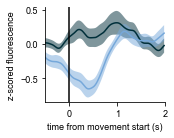

In [42]:
font = {'size': 9}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family']


contra_mean_trace = decimate(np.nanmean(all_mice_contra_traces, axis=0)[inds_to_plot], 10)
ipsi_mean_trace = decimate(np.nanmean(all_mice_ipsi_traces, axis=0)[inds_to_plot], 10)
fig, axs = plt.subplots(1, 1, figsize=[2.5, 2])

axs.plot(time_points_for_plot, contra_mean_trace, color='#002F3A')
axs.plot(time_points_for_plot, ipsi_mean_trace, color='#76A8DA')

contra_error_bar_lower, contra_error_bar_upper = calculate_error_bars(contra_mean_trace,
                                                                decimate(all_mice_contra_traces[:, inds_to_plot[0]],10) ,
                                                                error_bar_method='sem')
axs.fill_between(time_points_for_plot, contra_error_bar_lower, contra_error_bar_upper, alpha=0.5,
                            facecolor='#002F3A', linewidth=0)

ipsi_error_bar_lower, ipsi_error_bar_upper = calculate_error_bars(ipsi_mean_trace,
                                                                decimate(all_mice_ipsi_traces[:, inds_to_plot[0]], 10),
                                                                error_bar_method='sem')
axs.fill_between(time_points_for_plot, ipsi_error_bar_lower, ipsi_error_bar_upper, alpha=0.5,
                            facecolor='#76A8DA', linewidth=0)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')

axs.axvline(0, color='k')
axs.set_ylabel('z-scored fluorescence')
axs.set_xlabel('time from movement start (s)')
plt.tight_layout()
axs.set_xlim(window_to_plot)

figure_dir = r'T:\paper\revisions\return to centre'
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'return_to_centre_average_traces_all_mice_min20trials.pdf'))
plt.savefig(os.path.join(figure_dir, 'return_to_centre_average_traces_all_mice_min_20_trials.svg'))

plt.show()



# Example mouse

In [43]:
mouse = 'SNL_photo21'
num_sessions = 3
site = 'tail'

time_points = np.linspace(-5, 5, 100000)

experiments = experiments_to_process[experiments_to_process['mouse_id'] == mouse].reset_index(drop=True)
contra_movement_traces = np.zeros([num_sessions, 100000])
ipsi_movement_traces = np.zeros([num_sessions, 100000])
for index, experiment in experiments.iterrows():
    mouse = experiment['mouse_id']
    date = experiment['date']
    save_dir = 'T:\\photometry_2AC\\processed_data\\return_to_centre\\{}'.format(mouse)
    save_file = '{}_{}_return_to_centre_traces_aligned_to_movement_start_turn_ang_thresh_300frame_window.npz'.format(mouse, date)
    traces = np.load(os.path.join(save_dir, save_file))
    print(traces['ipsi_movement'].shape, traces['contra_movement'].shape)
    if traces['ipsi_movement'].shape[1] >= 20 or traces['contra_movement'].shape[1] >= 20:
        contra_movement_traces[index, :] = np.mean(traces['contra_movement'], axis=1)
        ipsi_movement_traces[index, :] = np.mean(traces['ipsi_movement'], axis=1)
    else:
        contra_movement_traces[index, :] = np.nan
        ipsi_movement_traces[index, :] = np.nan


(100000, 37) (100000, 157)
(100000, 15) (100000, 24)
(100000, 87) (100000, 122)


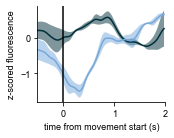

In [44]:
font = {'size': 9}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.family']


fig, axs = plt.subplots(1, 1, figsize=[2.5, 2])
ipsi_mean_trace = decimate(np.nanmean(ipsi_movement_traces, axis=0)[inds_to_plot],10)
contra_mean_trace = decimate(np.nanmean(contra_movement_traces, axis=0)[inds_to_plot],10)
axs.plot(time_points_for_plot, contra_mean_trace, color='#002F3A')
axs.plot(time_points_for_plot, ipsi_mean_trace, color='#76A8DA')

contra_error_bar_lower, contra_error_bar_upper = calculate_error_bars(contra_mean_trace,
                                                                decimate(contra_movement_traces[:, inds_to_plot[0]],10) ,
                                                                error_bar_method='sem')
axs.fill_between(time_points_for_plot, contra_error_bar_lower, contra_error_bar_upper, alpha=0.5,
                            facecolor='#002F3A', linewidth=0)

ipsi_error_bar_lower, ipsi_error_bar_upper = calculate_error_bars(ipsi_mean_trace,
                                                                decimate(ipsi_movement_traces[:, inds_to_plot[0]], 10),
                                                                error_bar_method='sem')
axs.fill_between(time_points_for_plot, ipsi_error_bar_lower, ipsi_error_bar_upper, alpha=0.5,
                            facecolor='#76A8DA', linewidth=0)


axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.yaxis.set_ticks_position('left')
axs.xaxis.set_ticks_position('bottom')

axs.axvline(0, color='k')
axs.set_ylabel('z-scored fluorescence')
axs.set_xlabel('time from movement start (s)')
plt.tight_layout()
axs.set_xlim(window_to_plot)

figure_dir = r'T:\paper\revisions\return to centre'
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'return_to_centre_average_traces_example_min20trials.pdf'))
plt.savefig(os.path.join(figure_dir, 'return_to_centre_average_traces_example_min_20_trials.svg'))

plt.show()


array([nan, nan, nan, ..., nan, nan, nan])